### Make a binary classification dataset with Scikit-Learn's make_moons() function.

    For consistency, the dataset should have 1000 samples and a random_state=42.
    Turn the data into PyTorch tensors. Split the data into training and test sets using train_test_split with 80% training and 20% testing.


In [ ]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchmetrics.classification import BinaryAccuracy, MulticlassAccuracy
from helper_functions import plot_decision_boundary


n_samples = 1000

X, y = make_moons(n_samples,noise=0.03,random_state=42)
len(X), len(y)

In [2]:
moons = pd.DataFrame({"X1":X[:,0], "X2":X[:,1],"label": y})

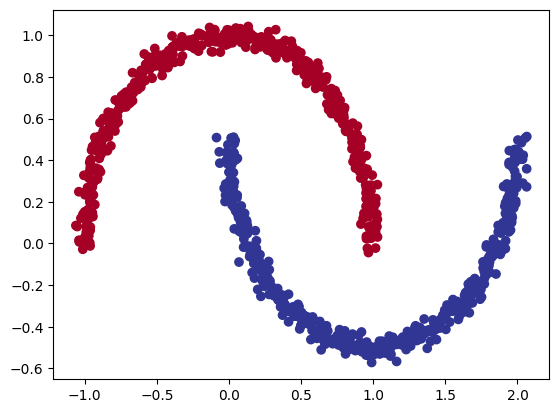

In [3]:
plt.scatter(X[:,0],X[:,1],c=y,cmap=plt.cm.RdYlBu)

In [4]:
# Fix the type of the data
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
X[0],y[0]

(tensor([-0.0093,  0.3910]), tensor(1.))

In [5]:
X_moon_train,X_moon_test,y_moon_train,y_moon_test = train_test_split(X,y, train_size=0.8)
len(X_moon_train),len(y_moon_train)

(800, 800)

### Build a model by subclassing nn.Module that incorporates non-linear activation functions and is capable of fitting the data you created in 1.

   Feel free to use any combination of PyTorch layers (linear and non-linear) you want.


In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [7]:
class MoonClassification(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=2,out_features=8),
            nn.ReLU(),
            nn.Linear(in_features=8,out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16,out_features=8),
            nn.ReLU(),
            nn.Linear(in_features=8,out_features=1),
        )
    def forward(self,X):
        return self.layer_stack(X)
    
model_0 = MoonClassification().to(device)

### Setup a binary classification compatible loss function and optimizer to use when training the model.

In [8]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(lr=0.03,params=model_0.parameters())

### Create a training and testing loop to fit the model you created in 2 to the data you created in 1.

    To measure model accuracy, you can create your own accuracy function or use the accuracy function in TorchMetrics.
    Train the model for long enough for it to reach over 96% accuracy.
    The training loop should output progress every 10 epochs of the model's training and test set loss and accuracy.


In [9]:
X_moon_train, y_moon_train = X_moon_train.to(device),y_moon_train.to(device)
X_moon_test, y_moon_test = X_moon_test.to(device), y_moon_test.to(device)

accuracy_fn = BinaryAccuracy().to(device)

epochs = 100
for epoch in range(epochs):
    model_0.train()

    y_logits = model_0(X_moon_train).squeeze()
    y_pred_probs = torch.sigmoid(y_logits)
    y_preds = torch.round(y_pred_probs)

    loss = loss_fn(y_logits,y_moon_train)
    acc = accuracy_fn(y_preds,y_moon_train)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_0.eval()
    with torch.inference_mode():
        y_test_logits = model_0(X_moon_test).squeeze()
        # Skipping y_test_probs
        y_test_preds = torch.round(torch.sigmoid(y_test_logits))
        y_test_loss = loss_fn(y_test_logits,y_moon_test)

        test_acc = accuracy_fn(y_test_preds,y_moon_test)
    if epoch % 10 == 0:
        print(f"{epoch} Loss: {loss:4f} | Accuracy: {acc:2f} | Test Loss: {y_test_loss:4f} | Test Accuracy: {test_acc:2f}")


0 Loss: 0.714796 | Accuracy: 0.510000 | Test Loss: 0.726246 | Test Accuracy: 0.460000
10 Loss: 0.708243 | Accuracy: 0.510000 | Test Loss: 0.717432 | Test Accuracy: 0.460000
20 Loss: 0.703760 | Accuracy: 0.510000 | Test Loss: 0.711203 | Test Accuracy: 0.460000
30 Loss: 0.700699 | Accuracy: 0.510000 | Test Loss: 0.706893 | Test Accuracy: 0.460000
40 Loss: 0.698495 | Accuracy: 0.510000 | Test Loss: 0.703728 | Test Accuracy: 0.460000
50 Loss: 0.696735 | Accuracy: 0.510000 | Test Loss: 0.701212 | Test Accuracy: 0.460000
60 Loss: 0.695256 | Accuracy: 0.510000 | Test Loss: 0.699136 | Test Accuracy: 0.460000
70 Loss: 0.693961 | Accuracy: 0.510000 | Test Loss: 0.697374 | Test Accuracy: 0.460000
80 Loss: 0.692799 | Accuracy: 0.510000 | Test Loss: 0.695838 | Test Accuracy: 0.460000
90 Loss: 0.691725 | Accuracy: 0.510000 | Test Loss: 0.694472 | Test Accuracy: 0.460000


### Make predictions with your trained model and plot them using the plot_decision_boundary() function created in this notebook.

In [10]:
model_0.eval()
with torch.inference_mode():
    y_test_logits = model_0(X_moon_test)
    y_preds = torch.round(torch.sigmoid(y_test_logits))

print(y_preds[:10],y_moon_test[:10])


tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0') tensor([0., 0., 0., 0., 0., 0., 1., 1., 0., 0.], device='cuda:0')


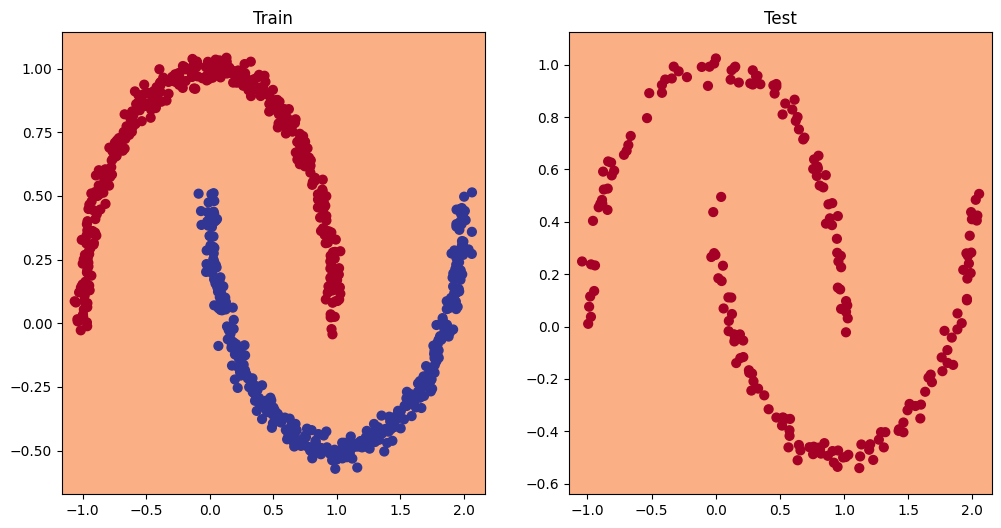

In [11]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model=model_0,X=X_moon_train,y=y_moon_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model=model_0,X=X_moon_test,y=y_test_preds)

### Replicate the Tanh (hyperbolic tangent) activation function in pure PyTorch.

    Feel free to reference the ML cheatsheet website for the formula.


In [12]:
# Pytorch version
def tanh(x):
    x = torch.tensor(x)
    return (torch.exp(x) - torch.exp(-x)) / (torch.exp(x) + torch.exp(-x)) 


In [13]:
tanh(1)

tensor(0.7616)

In [14]:
# numpy version
def tanh2(z):
	return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))

In [15]:
tanh2(1)

0.7615941559557649

### Create a multi-class dataset using the spirals data creation function from CS231n (see below for the code).

    Construct a model capable of fitting the data (you may need a combination of linear and non-linear layers).
    Build a loss function and optimizer capable of handling multi-class data (optional extension: use the Adam optimizer instead of SGD, you may have to experiment with different values of the learning rate to get it working).
    Make a training and testing loop for the multi-class data and train a model on it to reach over 95% testing accuracy (you can use any accuracy measuring function here that you like).
    Plot the decision boundaries on the spirals dataset from your model predictions, the plot_decision_boundary() function should work for this dataset too.


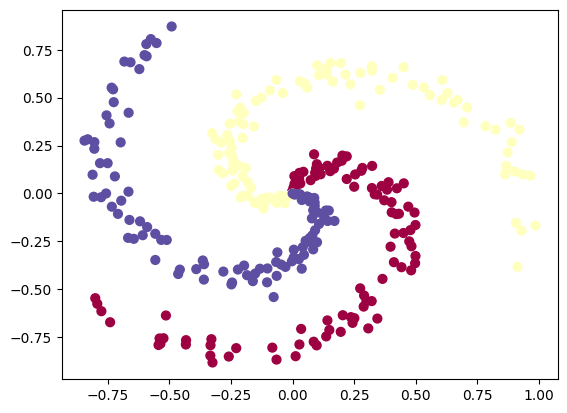

In [16]:
# Code for creating a spiral dataset from CS231n
import numpy as np
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [17]:
X = torch.from_numpy(X).type(torch.float) # features as float32
y = torch.from_numpy(y).type(torch.LongTensor) # labels need to be of type long

In [33]:
X_spiral_train,X_spiral_test,y_spiral_train,y_spiral_test = train_test_split(X,y,test_size=0.2,random_state=42)
print(X_spiral_train.dtype, X_spiral_test.dtype, y_spiral_train.dtype, y_spiral_test.dtype)

torch.float32 torch.float32 torch.int64 torch.int64


In [34]:
class SpiralMultiClassClassification(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=2,out_features=8),
            nn.ReLU(),
            nn.Linear(in_features=8,out_features=8),
            nn.ReLU(),
            nn.Linear(in_features=8,out_features=8),
            nn.ReLU(),
            nn.Linear(in_features=8,out_features=3),

        ) 
    def forward(self,X):
        return self.layer_stack(X)
model_1 = SpiralMultiClassClassification().to(device)

In [35]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(lr=0.01,params=model_1.parameters())

In [36]:
X_spiral_train, y_spiral_train = X_spiral_train.to(device),y_spiral_train.to(device)
X_spiral_test, y_spiral_test = X_spiral_test.to(device), y_spiral_test.to(device)

In [37]:
accuracy_fn = MulticlassAccuracy(num_classes=3).to(device)

epochs = 200
for epoch in range(epochs):
    model_1.train()

    y_logits = model_1(X_spiral_train)
    y_preds = torch.softmax(y_logits,dim=1).argmax(dim=1)
    

    loss = loss_fn(y_logits,y_spiral_train)
    acc = accuracy_fn(y_preds,y_spiral_train)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_1.eval()
    with torch.inference_mode():
        y_test_logits = model_1(X_spiral_test)
        # Skipping y_test_probs
        y_test_preds = torch.softmax(y_test_logits,dim=1).argmax(dim=1)
        y_test_loss = loss_fn(y_test_logits,y_spiral_test)

        test_acc = accuracy_fn(y_test_preds,y_spiral_test)
    if epoch % 10 == 0:
        print(f"{epoch} Loss: {loss:4f} | Accuracy: {acc:2f} | Test Loss: {y_test_loss:4f} | Test Accuracy: {test_acc:2f}")


0 Loss: 1.103269 | Accuracy: 0.333333 | Test Loss: 1.120079 | Test Accuracy: 0.333333
10 Loss: 1.078788 | Accuracy: 0.333333 | Test Loss: 1.086897 | Test Accuracy: 0.363636
20 Loss: 1.009373 | Accuracy: 0.541514 | Test Loss: 1.016441 | Test Accuracy: 0.621212
30 Loss: 0.881024 | Accuracy: 0.491453 | Test Loss: 0.892905 | Test Accuracy: 0.456439
40 Loss: 0.803115 | Accuracy: 0.555861 | Test Loss: 0.836293 | Test Accuracy: 0.577652
50 Loss: 0.719281 | Accuracy: 0.553114 | Test Loss: 0.749992 | Test Accuracy: 0.517045
60 Loss: 0.666460 | Accuracy: 0.565629 | Test Loss: 0.705135 | Test Accuracy: 0.547348
70 Loss: 0.608159 | Accuracy: 0.632479 | Test Loss: 0.643981 | Test Accuracy: 0.577652
80 Loss: 0.547759 | Accuracy: 0.670330 | Test Loss: 0.567777 | Test Accuracy: 0.683712
90 Loss: 0.467479 | Accuracy: 0.742369 | Test Loss: 0.470160 | Test Accuracy: 0.714015
100 Loss: 0.376219 | Accuracy: 0.804640 | Test Loss: 0.375631 | Test Accuracy: 0.780303
110 Loss: 0.297848 | Accuracy: 0.850427 | T

In [38]:
model_1.eval()
with torch.inference_mode():
    y_pred_logits = model_1(X_spiral_test)
    y_preds = torch.softmax(y_pred_logits,dim=1).argmax(dim=1)
    

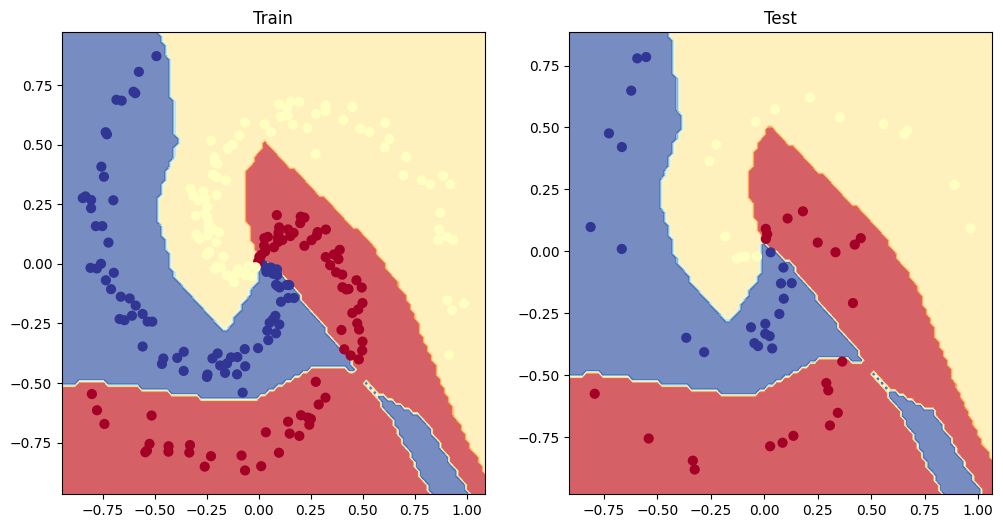

In [39]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1,X_spiral_train,y_spiral_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1,X_spiral_test,y_spiral_test)